In [ ]:
!pip3 install pyro-ppl
!pip3 install sklearn
!pip3 install arviz
!pip3 install numpy
!pip3 install matplotlib

In [19]:
import pyro
import torch
import pyro.distributions as pdist
import torch.distributions as tdist
import arviz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import tqdm

# Exercise1

In [25]:
np.random.seed(0)
sns.set_theme()
palette = sns.color_palette()

def p_density(x):
    return np.exp(-(x**2) / 2) * (
        np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    )


def rejection_sample(q_density, x_func, k=1, n_samples=1000) -> np.ndarray:
    samples = np.zeros((n_samples))
    for i in range(n_samples):
        ratio = 0
        u = 1
        while ratio < u:
            u = np.random.uniform(0, 1)
            x = x_func()
            ratio = p_density(x) / (k * q_density(x))
        samples[i] = x
    return samples


# Self-normalized importance sampling
def importance_sample(q: scipy.stats.norm, n_samples=1000):
    xs = q.rvs(size=n_samples)
    q_samples = q.pdf(xs)
    p_samples = p_density(xs)
    w = (p_samples / q_samples) / np.sum(p_samples / q_samples)
    return np.sum(w * (xs**2))

In [38]:
def plot_densities(methods):
    method_name, method = list(methods.items())[1]
    xs = np.linspace(-3, 3, 1000)
    sns.lineplot(
        x=xs,
        y=scipy.stats.norm.pdf(xs) * k_normal,
        label=f"Normal envelope ($k={k_normal}$)",
    )
    sns.lineplot(
        x=xs,
        y=scipy.stats.uniform.pdf(xs, loc=-3, scale=6) * k_uniform,
        label=f"Uniform envelope ($k={k_uniform}$)",
    )
    sns.lineplot(
        x=np.linspace(-3, 3, 1000),
        y=p_density(np.linspace(-3, 3, 1000)),
        label="$p(x)$",
        color=palette[1],
    )
    samples = method(10000)
    sns.histplot(samples, stat="density", label="Samples", bins=100, color=palette[4])
    plt.savefig("figs/e1-reject.png")
    plt.clf()
    plt.show()

# Exercise3

In [3]:
from torch.distributions import constraints

class MyDensity(pdist.TorchDistribution):
    # The integration interval
    support = constraints.interval(torch.tensor(-3), torch.tensor(3))
    arg_constraints = {"start": support}

    def __init__(self, start=torch.tensor(0.0)):
      self.start = start
      super(pdist.TorchDistribution, self).__init__()

    def sample(self, sample_shape=torch.Size()):
        return self.start

    def log_prob(self, x):
        # Return log of the (unnormalized) density
        #return torch.exp(-x**2/2) * ((torch.sin(x))**2 + 3 * (torch.cos(x))**2 * (torch.sin(7 * x))**2 + 1)
        return -x**2 / 2 + torch.log(((torch.sin(x))**2 + 3 * (torch.cos(x))**2 * (torch.sin(7 * x))**2 + 1))

In [4]:
def model():
    x=pyro.sample("x", MyDensity())

In [5]:
# Run HMC / NUTS
nuts_kernel = pyro.infer.NUTS(model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1000, num_chains=1, warmup_steps=500)
mcmc.run()

Sample: 100%|███████████████████████████████████████| 1500/1500 [00:04, 349.78it/s, step size=1.40e-01, acc. prob=0.910]                                           


In [6]:
# Get the samples
samples = mcmc.get_samples()["x"]

# Calculate E(x^2)
print(torch.mean(samples**2).item())

1.1181451082229614


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  0.053  1.057  -2.062    1.889      0.104    0.074     105.0      77.0   

   r_hat  
x    NaN  


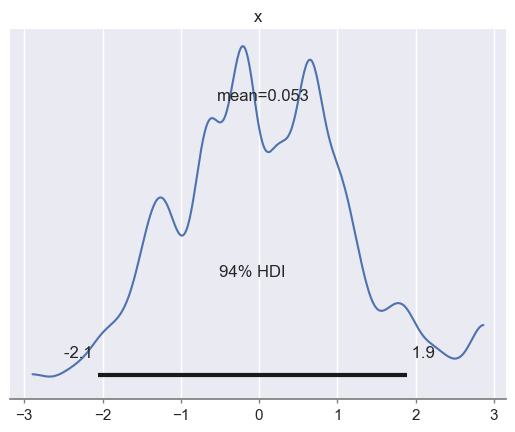

In [39]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)

print(summary)
arviz.plot_posterior(data)
plt.savefig('figs/e3.png')
plt.show()

In [35]:
def HMC(n_samples):
    print(n_samples)
    # Run HMC / NUTS
    nuts_kernel = pyro.infer.NUTS(model)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples, num_chains=1, warmup_steps=500)
    mcmc.run()
    
    # Get the samples
    samples = mcmc.get_samples()["x"]

    # Calculate E(x^2)
    return (torch.mean(samples**2).item())

# Plot everything

In [36]:
k_uniform = 23
k_normal = 10

# Estimate E[x^2] by rejection sample x in in [-3, 3]
methods = {
    "RS normal": lambda n: rejection_sample(
        scipy.stats.norm.pdf, np.random.normal, k=k_normal, n_samples=n
    ),
    "RS uniform": lambda n: rejection_sample(
        lambda x: scipy.stats.uniform.pdf(x, loc=-3, scale=6),
        lambda: np.random.uniform(-3, 3),
        k=k_uniform,
        n_samples=n,
    ),
    "HMC": lambda n: HMC(n)
}

In [37]:
plot_densities(methods)

<Figure size 640x480 with 0 Axes>

In [41]:
n_estimates = 10
data = pd.DataFrame(columns=["proposal", "n_samples", "estimate"])
for _ in tqdm.trange(n_estimates):
    for n_samples in (10, 100, 1000):
        for name, sample_method in methods.items():
            samples = sample_method(n_samples)
            estimate = samples if name=="HMC" else np.mean(samples**2)
            
            row = pd.DataFrame(
                {"proposal": name, "n_samples": n_samples, "estimate": estimate},
                index=[0],
            )
            data = pd.concat([data, row], ignore_index=True)
            
        row = pd.DataFrame(
            {
                "proposal": "IS normal",
                "n_samples": n_samples,
                "estimate": importance_sample(scipy.stats.norm, n_samples=n_samples),
            },
            index=[0],
        )
        
        data = pd.concat([data, row], ignore_index=True)

actual_mean = np.mean([p_density(x) * x**2 for x in (np.linspace(-3, 3, 10_000))])

sns.barplot(data=data, x="n_samples", y="estimate", hue="proposal", errorbar="sd")
plt.axhline(actual_mean, color="black", linestyle="--", label="Actual")
plt.xlabel("Number of samples")
plt.ylabel("$E[x^2]$")

plt.savefig("figs/e1_and_3.png")
plt.clf()

print(data.groupby(["proposal", "n_samples"]).mean())
print(data.groupby(["proposal", "n_samples"]).std())
print("Actual:", actual_mean)

print("IS: ", importance_sample(scipy.stats.norm))


  0%|                                                                                                                                       | 0/10 [00:00<?, ?it/s]/var/folders/3m/t5ftv_1d5tj5szs3txjmqx7w0000gn/T/ipykernel_12156/4002549357.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, row], ignore_index=True)


10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 476.50it/s, step size=1.34e-01, acc. prob=0.952]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 423.48it/s, step size=1.45e-01, acc. prob=0.816]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 386.31it/s, step size=1.71e-01, acc. prob=0.917]                                           

 10%|████████████▋                                                                                                                  | 1/10 [00:06<00:59,  6.65s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 375.80it/s, step size=2.64e-01, acc. prob=0.820]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 468.27it/s, step size=1.01e-01, acc. prob=0.907]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 407.71it/s, step size=1.31e-01, acc. prob=0.922]                                           

 20%|█████████████████████████▍                                                                                                     | 2/10 [00:13<00:52,  6.62s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 387.94it/s, step size=1.48e-01, acc. prob=0.552]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 404.32it/s, step size=1.97e-01, acc. prob=0.818]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 428.26it/s, step size=1.18e-01, acc. prob=0.840]                                           

 30%|██████████████████████████████████████                                                                                         | 3/10 [00:19<00:46,  6.60s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 396.98it/s, step size=1.90e-01, acc. prob=0.810]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 437.51it/s, step size=1.87e-01, acc. prob=0.791]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 406.00it/s, step size=1.48e-01, acc. prob=0.878]                                           

 40%|██████████████████████████████████████████████████▊                                                                            | 4/10 [00:26<00:39,  6.60s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 442.85it/s, step size=1.73e-01, acc. prob=0.928]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 444.67it/s, step size=2.10e-01, acc. prob=0.760]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 473.69it/s, step size=2.84e-01, acc. prob=0.730]                                           

 50%|███████████████████████████████████████████████████████████████▌                                                               | 5/10 [00:32<00:31,  6.36s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 407.13it/s, step size=2.15e-01, acc. prob=0.833]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 463.58it/s, step size=1.76e-01, acc. prob=0.804]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 411.79it/s, step size=1.40e-01, acc. prob=0.904]                                           

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 6/10 [00:38<00:25,  6.38s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 414.82it/s, step size=1.95e-01, acc. prob=0.807]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 468.01it/s, step size=1.90e-01, acc. prob=0.772]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 434.17it/s, step size=2.16e-01, acc. prob=0.865]                                           

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7/10 [00:45<00:19,  6.34s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 426.03it/s, step size=1.89e-01, acc. prob=0.724]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 460.37it/s, step size=1.11e-01, acc. prob=0.839]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 461.07it/s, step size=2.63e-01, acc. prob=0.767]                                           

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8/10 [00:51<00:12,  6.24s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 422.73it/s, step size=1.67e-01, acc. prob=0.794]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 398.39it/s, step size=1.04e-01, acc. prob=0.927]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 421.74it/s, step size=1.57e-01, acc. prob=0.861]                                           

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9/10 [00:57<00:06,  6.34s/it]

10


Sample: 100%|█████████████████████████████████████████| 510/510 [00:01, 378.49it/s, step size=1.68e-01, acc. prob=0.676]                                           


100


Sample: 100%|█████████████████████████████████████████| 600/600 [00:01, 393.69it/s, step size=1.65e-01, acc. prob=0.771]                                           


1000


Sample: 100%|███████████████████████████████████████| 1500/1500 [00:03, 400.91it/s, step size=1.06e-01, acc. prob=0.827]                                           

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.45s/it]


                      estimate
proposal   n_samples          
HMC        10         0.426187
           100        0.781449
           1000       0.928389
IS normal  10         0.905594
           100        0.893813
           1000       0.916728
RS normal  10         0.914293
           100        0.996311
           1000       0.935988
RS uniform 10         1.014371
           100        0.869217
           1000       0.920134
                      estimate
proposal   n_samples          
HMC        10         0.586384
           100        0.195113
           1000       0.114704
IS normal  10         0.462499
           100        0.100309
           1000       0.042745
RS normal  10         0.265726
           100        0.119718
           1000       0.019828
RS uniform 10         0.213612
           100        0.122503
           1000       0.049884
Actual: 0.870506326086464
IS:  1.0047795421307473


<Figure size 640x480 with 0 Axes>